In [1]:
from glob import iglob
from datetime import datetime
from itertools import chain, repeat, islice
from cytoolz import partition

import numpy as np
import pandas as pd
from cytoolz import compose, reduce
from h5py import File
from dask import delayed, compute
from dask.bag import from_sequence
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt

In [3]:
def read_spectra(filename: str):
    with File(filename, "r") as f:
        try:
            x0 = 500
            x1 = f["/photon_diagnostics/Spectrometer/Wavelength"][...]
            a = (
                f["/photon_diagnostics/Spectrometer/WavelengthSpan"][...]
                * f["/photon_diagnostics/Spectrometer/Pixel2micron"][...]
                / 1000
            )
            arr = f["/photon_diagnostics/Spectrometer/hor_spectrum"][...]
            _, n = arr.shape
            # x = a * (np.arange(n) - x0) + x1
            x = np.arange(n)
            for y in arr:
                yield {"x": x, "y": y}
        except KeyError:
            return

In [5]:
runs = [292]
globbed = chain.from_iterable(iglob(f"Data/Run_{r:03d}/rawdata/*.h5") for r in runs)
filenames = sorted(fn for fn in set(globbed))
it = chain.from_iterable(
    read_spectra(fn)
    for fn in chain.from_iterable(repeat(filenames))
)

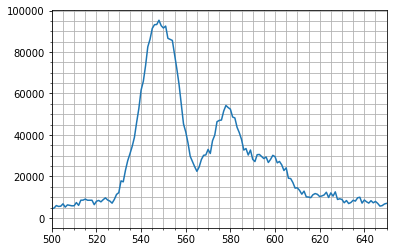

In [13]:
d = next(it)
plt.figure()
plt.plot(d["x"], d["y"])
plt.minorticks_on()
plt.grid(True, which="both")
plt.xlim(500, 650)
plt.show()